In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [3]:
cd "/root/SymmNeRF/"

/root/SymmNeRF


In [14]:
from opt import config_parser
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import setproctitle
import tqdm 
parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:0")
det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 0
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'

args.no_load_opt = True
args.no_load_scheduler = True

setproctitle.setproctitle('[Gaetan - SymmNeRF Test]')

In [15]:
# Create training dataset
from torch.utils.data import DataLoader,Subset
from datasets import dataset_dict, create_training_dataset
import matplotlib.pyplot as plt 


test_dataset = dataset_dict[args.eval_dataset](args,'test',args.eval_scene)

test_idx = np.random.randint(1,len(test_dataset),100)
test_subset = Subset(test_dataset,test_idx)
test_loader = DataLoader(test_subset,batch_size = 1,shuffle = True)

SRNsDataset:  /data/srn_cars/cars_test


### Model weights loading. 

In [6]:
from model.model import HyperNeRFResNetSymmLocal

#### Baseline model - SymmNeRF

In [10]:
args.with_vit = False
args.archCNN = 'resnet34'
args.local_feature_ch = 512
args.num_local_layers = 2
args.enforce_symmetry = {'status':False,
                         'on_coarse':False,'on_fine':False,
                         'concatenate_on_coarse':False, 'concatenate_on_fine':False}

args.feature = {'F':{'use_CNN':True,'use_VIT':False},
                'z':{'use_CNN':True,'use_VIT':False}
               }
model_baseline = HyperNeRFResNetSymmLocal(args,ckpts_folder = '/root/SymmNeRF/logs/srns_dataset/cars/baseline/ckpts')

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/baseline/ckpts/model_300000.pth, starting at step=300000


#### SymmNeRF model - EnforceSymm without concat

In [11]:
args.enforce_symmetry = {'status': True, 'on_coarse': True,'on_fine': True,'concatenate_on_coarse':False, 'concatenate_on_fine':False}
args.feature = {'F':{'use_CNN':True,'use_VIT':False},'z':{'use_CNN':True,'use_VIT':False}}
args.with_vit = False
args.archCNN = 'resnet34'
args.local_feature_ch = 512
args.num_local_layers = 2

model_enforce_symm_without_concat = HyperNeRFResNetSymmLocal(args,ckpts_folder = '/root/SymmNeRF/logs/srns_dataset/cars/doubleEnforceSymm/ckpts/')

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/doubleEnforceSymm/ckpts/model_300000.pth, starting at step=300000


#### SymmNeRF model - EnforceSymm with concat

In [12]:
args.enforce_symmetry = {'status': True, 'on_coarse': True,'on_fine': True,'concatenate_on_coarse':True, 'concatenate_on_fine':True}
args.feature = {'F':{'use_CNN':True,'use_VIT':False},'z':{'use_CNN':True,'use_VIT':False}}
args.with_vit = False
args.archCNN = 'resnet34'
args.local_feature_ch = 512
args.num_local_layers = 2

model_enforce_symm_with_concat = HyperNeRFResNetSymmLocal(args,ckpts_folder = '/root/SymmNeRF/logs/srns_dataset/cars/enforceSymmFineOnlyWithConcat/ckpts')

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/enforceSymmFineOnlyWithConcat/ckpts/model_400000.pth, starting at step=400000


#### Model with ViT and Hypernetwork 

In [13]:
args.with_vit = True
args.archCNN = 'resnet18_light'
args.local_feature_ch = 512
args.num_local_layers = 3
args.enforce_symmetry = {'status':False,
                         'on_coarse':False,'on_fine':False,
                         'concatenate_on_coarse':False, 'concatenate_on_fine':False}

args.feature = {'F':{'use_CNN':True,'use_VIT':True},
                'z':{'use_CNN':True,'use_VIT':False}
               }
model_vit = HyperNeRFResNetSymmLocal(args,ckpts_folder = '/root/SymmNeRF/logs/srns_dataset/cars/with_vit/ckpts')

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/with_vit/ckpts/model_300000.pth, starting at step=300000


#### Model with Vit but no CNN feature. 

In [14]:
args.with_vit = True
args.archCNN = 'resnet34'
args.local_feature_ch = 256
args.num_local_layers = 3
args.enforce_symmetry = {'status':False,
                         'on_coarse':False,'on_fine':False,
                         'concatenate_on_coarse':False, 'concatenate_on_fine':False}

args.feature = {'F':{'use_CNN':False,'use_VIT':True},
                'z':{'use_CNN':True,'use_VIT':False}
               }
model_vit_no_cnn_feature = HyperNeRFResNetSymmLocal(args,ckpts_folder = '/root/SymmNeRF/logs/srns_dataset/cars/with_vit_and_no_CNN_feature/ckpts')

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/with_vit_and_no_CNN_feature/ckpts/model_300000.pth, starting at step=300000


#### Model with ViT and CNN as in vision-NeRF

In [15]:
args.with_vit = True
args.archCNN = 'resnet-vision'
args.local_feature_ch = 256
args.num_local_layers = 3
args.enforce_symmetry = {'status':False,
                         'on_coarse':False,'on_fine':False,
                         'concatenate_on_coarse':False, 'concatenate_on_fine':False}
args.feature = {'F':{'use_CNN':True,'use_VIT':True},
                'z': {'use_CNN':False,'use_VIT':True}
                }
model_vit_vision = HyperNeRFResNetSymmLocal(args,ckpts_folder = '/root/SymmNeRF/logs/srns_dataset/cars/vision_with_symm/ckpts')

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/vision_with_symm/ckpts/model_300000.pth, starting at step=300000


In [16]:
from model.sample_ray import RaySampler
from model.render_ray import render_rays,render_single_image,get_intermediate_visuals
from model.projection import Projector 
from skimage import metrics
import lpips
from utils.general import *
import numpy as np 

In [ ]:
# Data to overfit on.
it = iter(test_loader)
test_data = next(it)

# Load training rays
ray_sampler = RaySampler(test_data)

In [17]:
# Symmetry matrix. 
M = torch.tensor([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]).to(device)

# Projector 
projector = Projector(device = device)

# LPIPS metrics
lpips_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth


In [18]:
idx_for_visuals = np.random.randint(0,100,20)
print(f'Selected indexes for visuals: {idx_for_visuals}')

Selected indexes for visuals: [24 73 53 22 32 22 20 99 38 39 32 75 20 29 18 55 44 48 94 11]


In [20]:
dict_res = {'baseline':{'psnr':[],'ssim':[],'lpips':[],'img_pred':[]},
            'enforceSymm_without_concat':{'psnr':[],'ssim':[],'lpips':[],'img_pred':[]},
            'enforceSymm_with_concat':{'psnr':[],'ssim':[],'lpips':[],'img_pred':[]},
            'vit':{'psnr':[],'ssim':[],'lpips':[],'img_pred':[]},
            'vit_no_CNN_feature':{'psnr':[],'ssim':[],'lpips':[],'img_pred':[]},
            'vit_vision':{'psnr':[],'ssim':[],'lpips':[],'img_pred':[]},
            'Is':[],
            'It':[]
           }
            
for i,test_data in enumerate(tqdm.tqdm(test_loader)):
    # Load training rays
    ray_sampler = RaySampler(test_data)
    
    render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
    render_list.remove(ray_sampler.src_view[0])

    render_views = np.random.choice(render_list, 1)

    for render_view in render_views: 
        
        ###########
        ## Baseline
        args.feature = {'F':{'use_CNN':True,'use_VIT':False},'z':{'use_CNN':True,'use_VIT':False}}
        args.enforce_symmetry = {'status':False,'on_coarse':False,'on_fine':False,'concatenate_on_coarse':False, 'concatenate_on_fine':False}
        Ipred1 = get_intermediate_visuals(args,model_baseline,projector,M,device,ray_sampler,render_view)
        Ipred1_np =Ipred1.numpy()
    
        #######
        ## ViT 
        args.feature = {'F':{'use_CNN':True,'use_VIT':True},'z':{'use_CNN':True,'use_VIT':False}}
        args.enforce_symmetry = {'status':False,'on_coarse':False,'on_fine':False,'concatenate_on_coarse':False, 'concatenate_on_fine':False}

        Ipred2 = get_intermediate_visuals(args,model_vit,projector,M,device,ray_sampler,render_view)
        Ipred2_np =Ipred2.numpy()
        
        ##################
        ## ViT without CNN
        args.feature = {'F':{'use_CNN':False,'use_VIT':True},'z':{'use_CNN':True,'use_VIT':False}}
        args.enforce_symmetry = {'status':False,'on_coarse':False,'on_fine':False,'concatenate_on_coarse':False, 'concatenate_on_fine':False}

        Ipred3 = get_intermediate_visuals(args,model_vit_no_cnn_feature,projector,M,device,ray_sampler,render_view)
        Ipred3_np =Ipred3.numpy()
        
        ########################################
        ## SymmNeRF - EnforceSymm without concat
        args.enforce_symmetry = {'status': True, 'on_coarse': True,'on_fine': True,'concatenate_on_coarse':False, 'concatenate_on_fine':False}
        args.feature = {'F':{'use_CNN':True,'use_VIT':False},'z':{'use_CNN':True,'use_VIT':False}}
        
        Ipred4 = get_intermediate_visuals(args,model_enforce_symm_without_concat,projector,M,device,ray_sampler,render_view)
        Ipred4_np =Ipred4.numpy()
        
        ########################################
        ## SymmNeRF - EnforceSymm with concat
        args.enforce_symmetry = {'status': True, 'on_coarse': True,'on_fine': True,'concatenate_on_coarse':True, 'concatenate_on_fine':True}
        args.feature = {'F':{'use_CNN':True,'use_VIT':False},'z':{'use_CNN':True,'use_VIT':False}}
        
        Ipred5 = get_intermediate_visuals(args,model_enforce_symm_with_concat,projector,M,device,ray_sampler,render_view)
        Ipred5_np =Ipred5.numpy()
        
        ################
        ## ViT - Vision
        args.enforce_symmetry = {'status':False,'on_coarse':False,'on_fine':False,'concatenate_on_coarse':False, 'concatenate_on_fine':False}
        args.feature = {'F':{'use_CNN':True,'use_VIT':True},'z': {'use_CNN':False,'use_VIT':True}}
        
        Ipred6 = get_intermediate_visuals(args,model_vit_vision,projector,M,device,ray_sampler,render_view)
        Ipred6_np = Ipred6.numpy()
        
        
        ##########################
        # Source and target images. 
        It = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0).cpu()
        It_np = It.numpy()
        Is = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)
        Is_np = Is.numpy()
        
        ##########
        # Metrics.
        psnr1 = metrics.peak_signal_noise_ratio(Ipred1_np,It_np)
        ssim1 = metrics.structural_similarity(Ipred1_np,It_np,multichannel = True,data_range = 1)
        lpips1 = lpips_vgg(Ipred1[None,...].permute(0,3,1,2).float().to(device),It[None,...].permute(0,3,1,2).float().to(device)).item()
        
        dict_res['baseline']['psnr'].append(psnr1)
        dict_res['baseline']['ssim'].append(ssim1)
        dict_res['baseline']['lpips'].append(lpips1)
        
        psnr2 = metrics.peak_signal_noise_ratio(Ipred2_np,It_np)
        ssim2 = metrics.structural_similarity(Ipred2_np,It_np,multichannel = True,data_range = 1)
        lpips2 = lpips_vgg(Ipred2[None,...].permute(0,3,1,2).float().to(device),It[None,...].permute(0,3,1,2).float().to(device)).item()
       
        dict_res['vit']['psnr'].append(psnr2)
        dict_res['vit']['ssim'].append(ssim2)
        dict_res['vit']['lpips'].append(lpips2)
        
        psnr3 = metrics.peak_signal_noise_ratio(Ipred3_np,It_np)
        ssim3 = metrics.structural_similarity(Ipred3_np,It_np,multichannel = True,data_range = 1)
        lpips3 = lpips_vgg(Ipred3[None,...].permute(0,3,1,2).float().to(device),It[None,...].permute(0,3,1,2).float().to(device)).item()
        
        dict_res['vit_no_CNN_feature']['psnr'].append(psnr3)
        dict_res['vit_no_CNN_feature']['ssim'].append(ssim3)
        dict_res['vit_no_CNN_feature']['lpips'].append(lpips3)
        
        psnr4 = metrics.peak_signal_noise_ratio(Ipred4_np,It_np)
        ssim4 = metrics.structural_similarity(Ipred4_np,It_np,multichannel = True,data_range = 1)
        lpips4 = lpips_vgg(Ipred4[None,...].permute(0,3,1,2).float().to(device),It[None,...].permute(0,3,1,2).float().to(device)).item()
        
        dict_res['enforceSymm_without_concat']['psnr'].append(psnr4)
        dict_res['enforceSymm_without_concat']['ssim'].append(ssim4)
        dict_res['enforceSymm_without_concat']['lpips'].append(lpips4)
        
        psnr5 = metrics.peak_signal_noise_ratio(Ipred5_np,It_np)
        ssim5 = metrics.structural_similarity(Ipred5_np,It_np,multichannel = True,data_range = 1)
        lpips5 = lpips_vgg(Ipred5[None,...].permute(0,3,1,2).float().to(device),It[None,...].permute(0,3,1,2).float().to(device)).item()
        
        dict_res['enforceSymm_with_concat']['psnr'].append(psnr5)
        dict_res['enforceSymm_with_concat']['ssim'].append(ssim5)
        dict_res['enforceSymm_with_concat']['lpips'].append(lpips5)
        
        psnr6 = metrics.peak_signal_noise_ratio(Ipred6_np,It_np)
        ssim6 = metrics.structural_similarity(Ipred6_np,It_np,multichannel = True,data_range = 1)
        lpips6 = lpips_vgg(Ipred6[None,...].permute(0,3,1,2).float().to(device),It[None,...].permute(0,3,1,2).float().to(device)).item()
        
        dict_res['vit_vision']['psnr'].append(psnr6)
        dict_res['vit_vision']['ssim'].append(ssim6)
        dict_res['vit_vision']['lpips'].append(lpips6)
        
        
        if i in idx_for_visuals:
            
            dict_res['baseline']['img_pred'].append(Ipred1_np)
            dict_res['vit']['img_pred'].append(Ipred2_np)
            dict_res['vit_no_CNN_feature']['img_pred'].append(Ipred3_np)
            dict_res['enforceSymm_without_concat']['img_pred'].append(Ipred4_np)
            dict_res['enforceSymm_with_concat']['img_pred'].append(Ipred5_np)
            dict_res['vit_vision']['img_pred'].append(Ipred6_np)
            
            dict_res['Is'].append(Is_np)
            dict_res['It'].append(It_np)
            
       

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2286189/505788145.py:80: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim1 = metrics.structural_similarity(Ipred1_np,It_np,multichannel = True,data_range = 1)
/tmp/ipykernel_2286189/505788145.py:88: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim2 = metrics.structural_similarity(Ipred2_np,It_np,multichannel = True,data_range = 1)
/tmp/ipykernel_2286189/505788145.py:96: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim3 = metrics.structural_similarity(Ipred3_np,It_np,multichannel = True,data_range = 1)
/tmp/ipykernel_2286189/505788145.py:104: FutureWarning: `multichannel` is a deprecated a

In [22]:
baseline_psnr = np.mean(dict_res['baseline']['psnr'])
baseline_ssim = np.mean(dict_res['baseline']['ssim'])
baseline_lpips = np.mean(dict_res['baseline']['lpips'])

vit_psnr = np.mean(dict_res['vit']['psnr'])
vit_ssim = np.mean(dict_res['vit']['ssim'])
vit_lpips = np.mean(dict_res['vit']['lpips'])

vit_vision_psnr = np.mean(dict_res['vit_vision']['psnr'])
vit_vision_ssim = np.mean(dict_res['vit_vision']['ssim'])
vit_vision_lpips = np.mean(dict_res['vit_vision']['lpips'])

vit_no_CNN_feature_psnr = np.mean(dict_res['vit_no_CNN_feature']['psnr'])
vit_no_CNN_feature_ssim = np.mean(dict_res['vit_no_CNN_feature']['ssim'])
vit_no_CNN_feature_lpips = np.mean(dict_res['vit_no_CNN_feature']['lpips'])

enforceSymm_without_concat_psnr = np.mean(dict_res['enforceSymm_without_concat']['psnr'])
enforceSymm_without_concat_ssim = np.mean(dict_res['enforceSymm_without_concat']['ssim'])
enforceSymm_without_concat_lpips = np.mean(dict_res['enforceSymm_without_concat']['lpips'])

enforceSymm_with_concat_psnr = np.mean(dict_res['enforceSymm_with_concat']['psnr'])
enforceSymm_with_concat_ssim = np.mean(dict_res['enforceSymm_with_concat']['ssim'])
enforceSymm_with_concat_lpips = np.mean(dict_res['enforceSymm_with_concat']['lpips'])

In [23]:
print(f''' ===============================================================================================================================================
psnr original: {baseline_psnr:.2f}dB, psnr ViT: {vit_psnr:.2f}dB, psnr ViT no CNN: {vit_no_CNN_feature_psnr:.2f}dB, psnr ViT Vision: {vit_vision_psnr:.2f}dB, psnr enforceSymm no concat: {enforceSymm_without_concat_psnr:.2f}dB, psnr enforceSymm with concat: {enforceSymm_with_concat_psnr:.2f}dB
ssim original: {baseline_ssim:.3f}, ssim ViT: {vit_ssim:.3f}, ssim ViT no CNN: {vit_no_CNN_feature_ssim:.3f}, ssim ViT Vision: {vit_vision_ssim:.3f}, ssim enforceSymm no concat: {enforceSymm_without_concat_ssim:.3f}, ssim enforceSymm with concat: {enforceSymm_with_concat_ssim:.3f}
lpips original: {baseline_lpips:.3f}, lpips ViT: {vit_lpips:.3f}, lpips ViT no CNN: {vit_no_CNN_feature_lpips:.3f}, lpips ViT Vision: {vit_vision_lpips:.3f},  lpips enforceSymm no concat: {enforceSymm_without_concat_lpips:.3f}dB, lpips enforceSymm with concat: {enforceSymm_with_concat_lpips:.3f}
=================================================================================================================================================''')

psnr original: 23.27dB, psnr ViT: 21.20dB, psnr ViT no CNN: 22.15dB, psnr ViT Vision: 18.49dB, psnr enforceSymm no concat: 21.94dB, psnr enforceSymm with concat: 22.89dB
ssim original: 0.905, ssim ViT: 0.877, ssim ViT no CNN: 0.887, ssim ViT Vision: 0.819, ssim enforceSymm no concat: 0.886, ssim enforceSymm with concat: 0.901
lpips original: 0.097, lpips ViT: 0.129, lpips ViT no CNN: 0.122, lpips ViT Vision: 0.177,  lpips enforceSymm no concat: 0.114dB, lpips enforceSymm with concat: 0.100


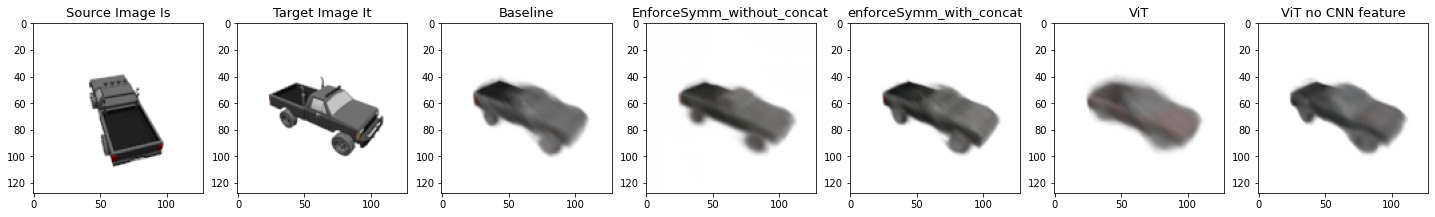

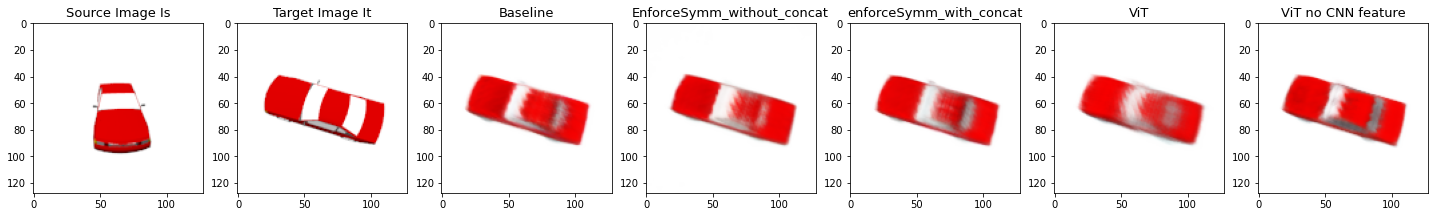

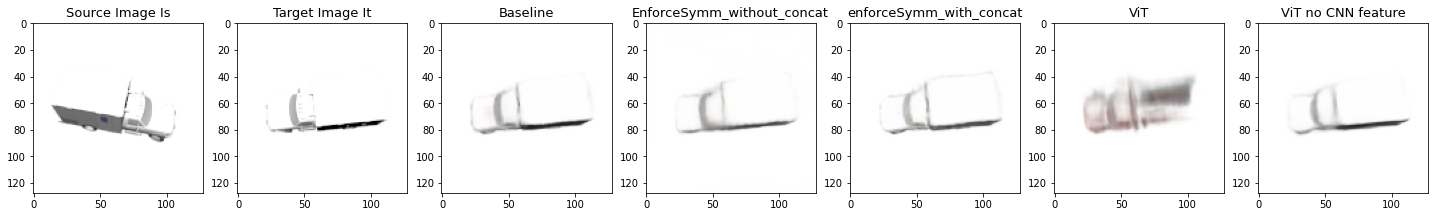

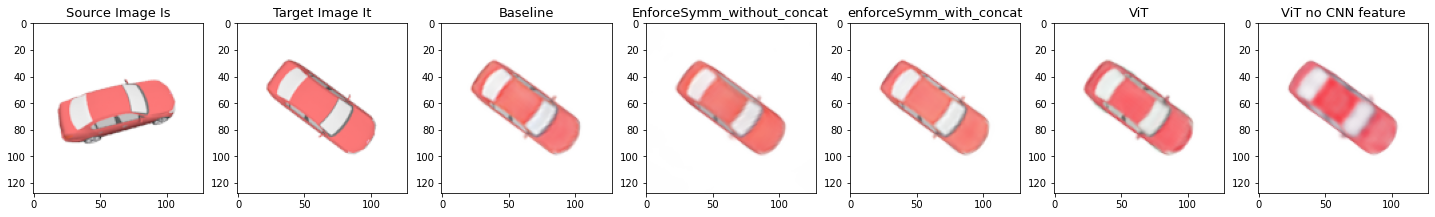

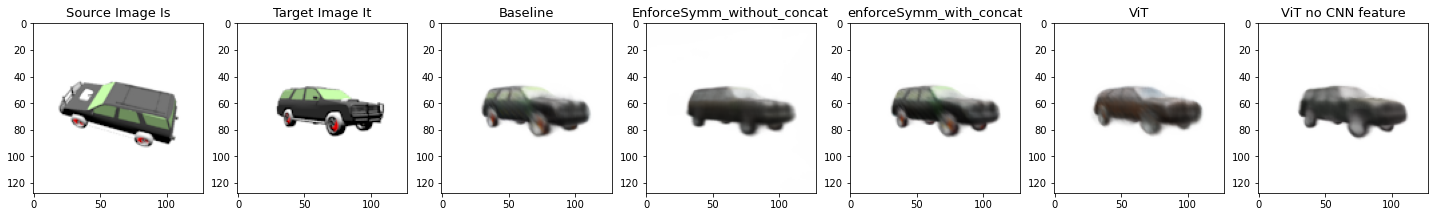

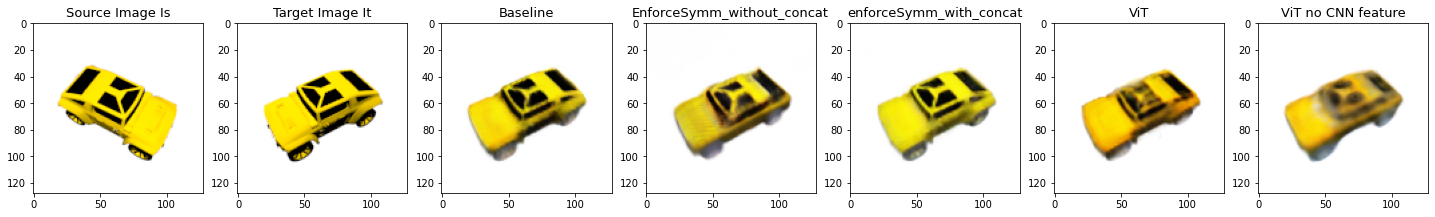

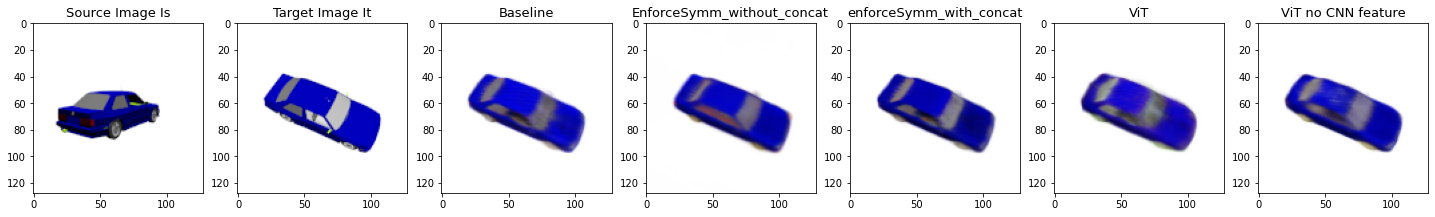

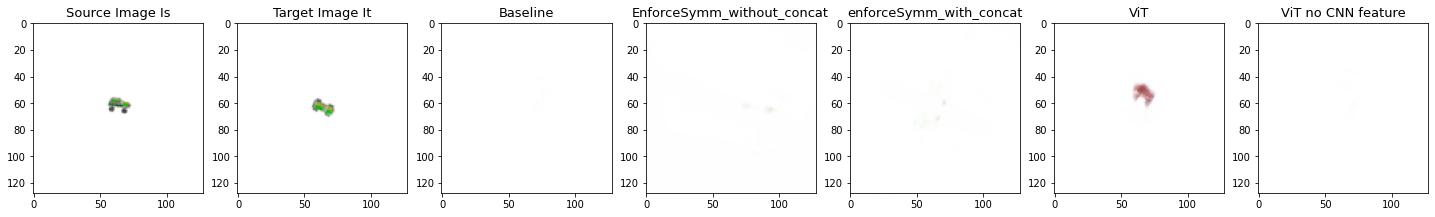

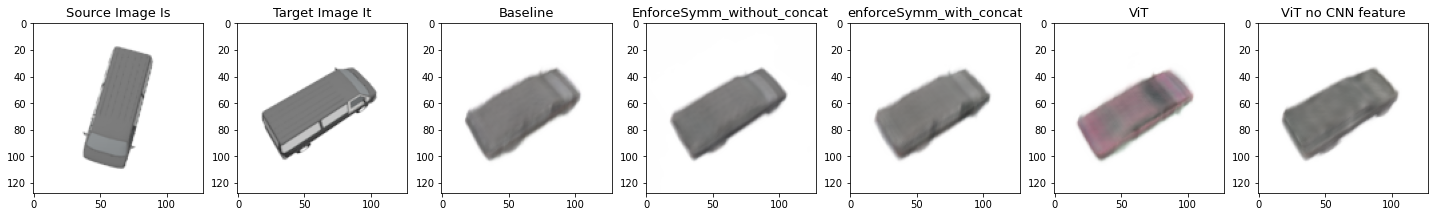

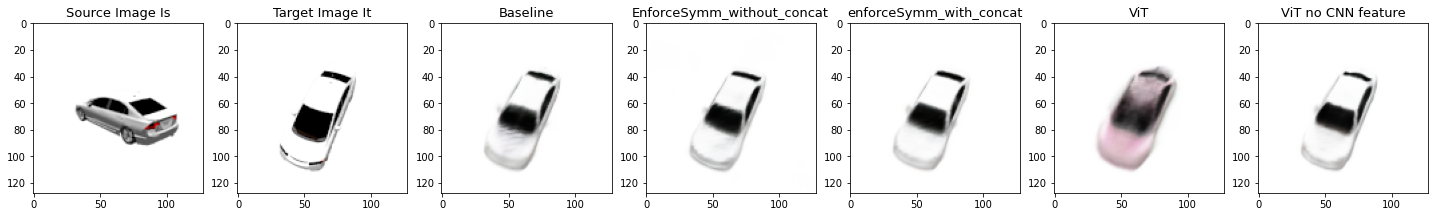

In [33]:
for i in range(len(idx_for_visuals)):
    fig, (ax1, ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1, 7, figsize=(25, 10))

    It = dict_res['It'][i]
    Is = dict_res['Is'][i]
    
    Ipred1 = dict_res['baseline']['img_pred'][i]
    Ipred2 = dict_res['vit']['img_pred'][i]
    Ipred3 = dict_res['vit_no_CNN_feature']['img_pred'][i]
    Ipred4 = dict_res['enforceSymm_without_concat']['img_pred'][i]
    Ipred5 = dict_res['enforceSymm_with_concat']['img_pred'][i]
    
    ax1.imshow(Is)
    ax2.imshow(It)
    ax3.imshow(Ipred1)
    ax4.imshow(Ipred4)
    ax5.imshow(Ipred5)
    ax6.imshow(Ipred2)
    ax7.imshow(Ipred3)
            
    ax1.set_title('Source Image Is', fontsize=13)
    ax2.set_title('Target Image It', fontsize=13)
    ax3.set_title('Baseline',fontsize=13)
    ax4.set_title('EnforceSymm_without_concat',fontsize=13)
    ax5.set_title('enforceSymm_with_concat',fontsize=13)
    ax6.set_title('ViT',fontsize=13)
    ax7.set_title('ViT no CNN feature',fontsize=13)